Dear FEMA,

We are excited to present our results for Task 3. In this task, we were asked to predict, for a given storm, the number of lightning events occurring per frame (based on the four bands), as well as their locations and the time they occurred.

In [ ]:
import warnings
warnings.filterwarnings('ignore')
from google.colab import drive
import numpy as np
import os
import pandas as pd

import torch
import torch.nn.functional as F
from torch.utils.data import  DataLoader
import sys
import torch.optim as optim

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path_copied = '/content/drive/MyDrive/ACDS-Barry/barry'
sys.path.append(path_copied)
from common_functions import load_event
from task_3 import LightningDataset, train_transform,plot_storm_images, train_model, UNet, DiceLoss, plot_model_predictions, get_data_loaders

The function get_data_loaders is composed of multiple components. Within this method, we call the DataClass, which performs several key operations.

One of the main challenges we encountered was handling the images, as the four bands had different image shapes. To address this, we opted for upscaling rather than downscaling to prevent loss of information, though this introduced some potential noise.

Additionally, we transformed the images since, in deep learning, it is generally recommended to keep pixel values within the range [0,1]. However, a key issue was that pixel intensity ranges varied not only between different images but also within the same band. To standardize this, we implemented the function safe_normalize, which ensures consistency across images.

After processing the data through the data loader, the output shape consists of:

Images as tensors: (num_batches, bands, image_shape)
Targets as tensors: (num_batches, image_shape)
Rather than keeping the initial targets in their original (N, 3) format, we transformed them into a grid-based representation. This approach allowed us to simplify processing, deferring spatial analysis to a later stage.

In [ ]:
project_path = "/content/drive/MyDrive/ACDS-Barry/data"
batch_size = 16

train_loader, val_loader, test_loader = get_data_loaders(project_path, batch_size=batch_size)

In [ ]:
for images, targets in train_loader:
    print("Train batch shape:", images.shape, targets.shape)
    break

Train batch shape: torch.Size([16, 4, 384, 384]) torch.Size([16, 384, 384])


This visualization displays the outputs of the data loader, where storms are mapped within the VIL band.

In [ ]:
images, targets = next(iter(train_loader))

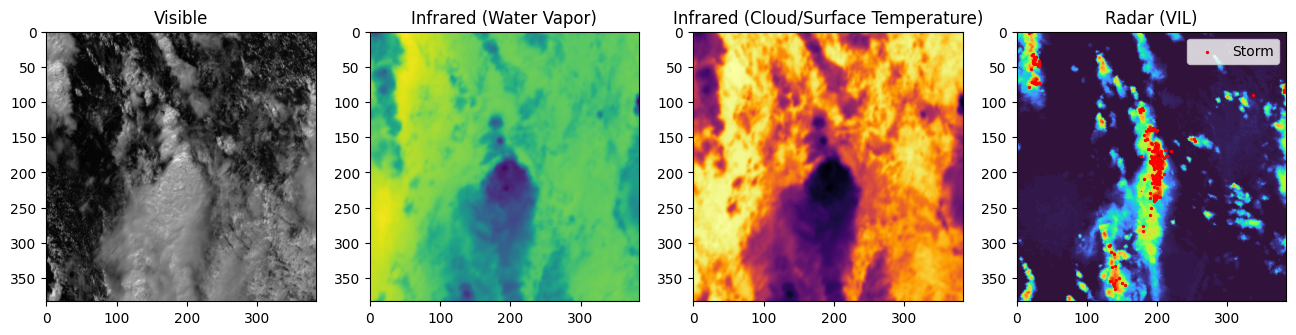

In [ ]:
plot_storm_images(images, targets, index=0)

As previously mentioned, we chose not to incorporate spatial analysis, opting to process each frame independently, thereby reducing dimensionality by excluding the alignment of 36 frames per storm. Initially, we experimented with models such as Conv-LSTM, 3D CNN, and 3D U-Net, all of which theoretically could yield satisfactory results. However, their outputs did not meet our expectations.

Consequently, we adopted a simpler approach: a U-Net architecture with four encoders and four decoders. The final layer of the U-Net utilized a ReLU activation function to ensure positive output values. We also experimented with the Softplus activation function, which produces outputs ranging from 0 to infinity. However, through hyperparameter tuning, ReLU proved to be more effective.

A significant concern was the choice of loss function. We tested various losses, but they did not consistently reflect model performance. For instance, using Mean Squared Error (MSE) Loss, we observed losses decreasing to 0.003; however, our grid outputted only zeros, as 99.8% of the grid contained zero values. To address this, we selected the Dice Loss, which assigns greater weight to non-zero values. This adjustment led to immediate improvements in outputs, even though the loss value was higher.

In [ ]:
model = UNet()
criterion = DiceLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

trained_model, train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=5)

Epoch 1/5 - Train Loss: 0.9966 - Val Loss: 0.9991
Epoch 2/5 - Train Loss: 0.9961 - Val Loss: 0.9993
Epoch 3/5 - Train Loss: 0.9964 - Val Loss: 0.9991
Epoch 4/5 - Train Loss: 0.9970 - Val Loss: 0.9991
Epoch 5/5 - Train Loss: 0.9968 - Val Loss: 0.9989


This notebook was run for only five epochs on a limited set of events for efficiency purposes. As a result, the model's output (grid) does not fully represent its expected performance compared to the trained model, which will be used in the next IPython notebook.

Nevertheless, the predicted lightning events correctly identify potential storm locations, even though the model tends to over-predict. This is preferable to under-prediction, as it takes a more precautionary approach.

In the next notebook (Surprise Storms), you will see how I transform this 2D grid into an (N,3) array, incorporating time information through interpolation.

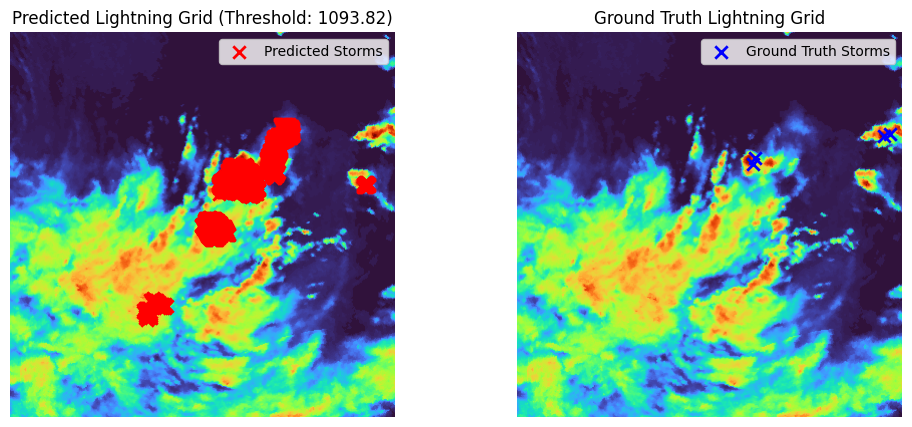

In [ ]:
plot_model_predictions(model, val_loader)

**Limitations and Potential Improvements**

The most obvious limitation is that spatial features were not incorporated using deep learning techniques. Instead, interpolation was applied later using basic linear mathematical operations.

Given more time, I could have conducted a more thorough literature review and optimized the implementation of a 3D U-Net, which may have better captured spatiotemporal dependencies.